In [1]:
import os
import glob
import cv2
import torch
import random
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

class ChestXrayDataset(Dataset):
    def __init__(self, df, root_path, transform=None, balance=False):
        self.transform = transform
        self.all_image_paths = []
        self.labels = []

        for image_name, label in zip(df['Image Index'], df['Finding Labels']):
            matched_paths = glob.glob(os.path.join(root_path, "images_*/images", image_name))
            if matched_paths:
                self.all_image_paths.append(matched_paths[0])
                self.labels.append(1 if 'Cardiomegaly' in label else 0)

        # if balance:
        #     self._balance_data()

    # def _balance_data(self):
    #     pos_samples = [(p, l) for p, l in zip(self.all_image_paths, self.labels) if l == 1]
    #     neg_samples = [(p, l) for p, l in zip(self.all_image_paths, self.labels) if l == 0]

    #     if len(pos_samples) == 0 or len(neg_samples) == 0:
    #         return

    #     if len(pos_samples) < len(neg_samples):
    #         pos_samples = random.choices(pos_samples, k=len(neg_samples))
    #     else:
    #         neg_samples = random.choices(neg_samples, k=len(pos_samples))

        # balanced = pos_samples + neg_samples
        # random.shuffle(balanced)
        # self.all_image_paths, self.labels = zip(*balanced)
        # self.all_image_paths = list(self.all_image_paths)
        # self.labels = list(self.labels)

    def __len__(self):
        return len(self.all_image_paths)

    def __getitem__(self, idx):
        image_path = self.all_image_paths[idx]
        label = torch.tensor(self.labels[idx]).float()
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if self.transform:
            image = self.transform(image)
        return image, label


In [2]:
base_path = "/kaggle/input/data"
df = pd.read_csv(f"{base_path}/Data_Entry_2017.csv")
df = df[df['View Position'] == 'PA'].reset_index(drop=True)
df['Cardiomegaly_Label'] = df['Finding Labels'].apply(lambda x: 1 if 'Cardiomegaly' in x else 0)
print(len(df))
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])



train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Cardiomegaly_Label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Cardiomegaly_Label'], random_state=42)

train_dataset = ChestXrayDataset(train_df, base_path, transform=train_transform)
val_dataset = ChestXrayDataset(val_df, base_path, transform=val_test_transform)
test_dataset = ChestXrayDataset(test_df, base_path, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)




67310
Device:  cuda


In [3]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

pos_weight = torch.tensor([
    len(train_df[train_df.Cardiomegaly_Label == 0]) / len(train_df[train_df.Cardiomegaly_Label == 1])
]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        preds = torch.sigmoid(outputs) >= 0.5
        correct += (preds.float() == labels).sum().item()
        total += labels.size(0)

        if batch_idx % 100 == 0:
            print(f"  [Batch {batch_idx}] Loss: {loss.item():.4f}")
    
    return total_loss / total, correct / total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    print("Starting evaluation...")
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            preds = torch.sigmoid(outputs) >= 0.5
            correct += (preds.float() == labels).sum().item()
            total += labels.size(0)

            if batch_idx % 100 == 0:
                print(f"  [Eval Batch {batch_idx}] Loss: {loss.item():.4f}")

    print("Finished evaluation.")
    return total_loss / total, correct / total

num_epochs = 20
    
best_val_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(num_epochs):
    print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "cardiomegaly_resnet18.pth")
        print("  ✅ Model improved and saved.")
    else:
        patience_counter += 1
        print(f"  ⏸ No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("  🛑 Early stopping triggered.")
            break


# print("\nEvaluating on test set...")
# test_loss, test_acc = evaluate(model, test_loader, criterion)
# print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

torch.save(model.state_dict(), "/kaggle/working/cardiomegaly_resnet18.pth")

print("Model saved to cardiomegaly_resnet18.pth")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s] 



=== Epoch 1/20 ===
  [Batch 0] Loss: 1.4962
  [Batch 100] Loss: 0.7479
  [Batch 200] Loss: 1.2367
  [Batch 300] Loss: 0.9159
  [Batch 400] Loss: 0.5754
  [Batch 500] Loss: 0.7620
  [Batch 600] Loss: 0.6559
  [Batch 700] Loss: 0.3488
  [Batch 800] Loss: 0.5807
  [Batch 900] Loss: 0.8597
  [Batch 1000] Loss: 0.5982
  [Batch 1100] Loss: 0.6623
  [Batch 1200] Loss: 3.4577
  [Batch 1300] Loss: 1.4061
  [Batch 1400] Loss: 2.6994
Starting evaluation...
  [Eval Batch 0] Loss: 0.9469
  [Eval Batch 100] Loss: 1.1617
  [Eval Batch 200] Loss: 0.3889
  [Eval Batch 300] Loss: 0.2215
Finished evaluation.
Epoch 1/20:
  Train Loss: 1.0198 | Train Acc: 0.7120
  Val   Loss: 0.8737 | Val   Acc: 0.9013
  ✅ Model improved and saved.

=== Epoch 2/20 ===
  [Batch 0] Loss: 2.4442
  [Batch 100] Loss: 1.4521
  [Batch 200] Loss: 0.3910
  [Batch 300] Loss: 0.4896
  [Batch 400] Loss: 0.7073
  [Batch 500] Loss: 0.4342
  [Batch 600] Loss: 1.4376
  [Batch 700] Loss: 0.4681
  [Batch 800] Loss: 0.3494
  [Batch 900] Los

 -> Image path: /kaggle/input/data/images_001/images/00000628_000.png Predicted: 1, Actual: 0
 -> Image path: /kaggle/input/data/images_008/images/00016837_001.png Predicted: 1, Actual: 0

=== Evaluation Metrics ===
Accuracy: 0.8668
Average Loss: 0.3113
Confusion Matrix:
[[8547 1315]
 [  30  205]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9965    0.8667    0.9271      9862
         1.0     0.1349    0.8723    0.2336       235

    accuracy                         0.8668     10097
   macro avg     0.5657    0.8695    0.5803     10097
weighted avg     0.9764    0.8668    0.9109     10097


Showing up to 5 misclassified images:


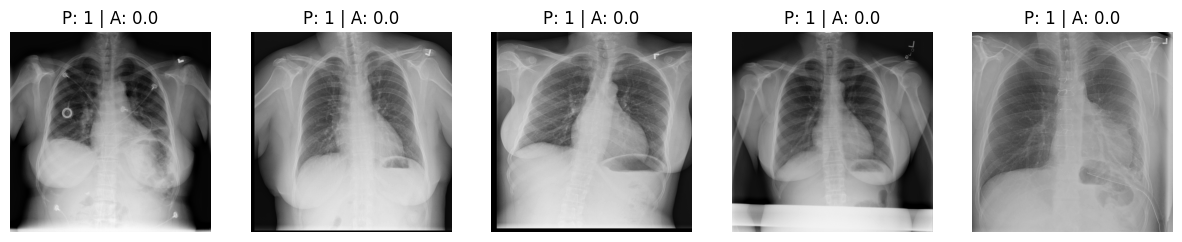

In [7]:
import torch
import matplotlib.pyplot as plt
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = torch.nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load("/kaggle/working/cardiomegaly_resnet18.pth", map_location=device))
model = model.to(device)
model.eval()

model.eval()

def evaluate_and_log_with_metrics(model, loader, criterion, dataset):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    all_preds = []
    all_labels = []
    all_image_paths = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)

            preds = (torch.sigmoid(outputs) >= 0.5).int()

            correct += (preds.float() == labels).sum().item()
            total += labels.size(0)

            # Save all predictions and labels for metrics
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

            # Save image paths for misclassification visualization
            for j in range(images.size(0)):
                index_in_dataset = i * loader.batch_size + j
                all_image_paths.append(dataset.all_image_paths[index_in_dataset])

                pred_val = int(preds[j].item())
                actual_val = int(labels[j].item())

                # Log only if predicted or actual is 1
                if pred_val == 1 or actual_val == 1:
                    image_path = dataset.all_image_paths[index_in_dataset]
                    print(f" -> Image path: {image_path} Predicted: {pred_val}, Actual: {actual_val}")

    accuracy = correct / total
    avg_loss = total_loss / total

    
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)

    print("\n=== Evaluation Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Average Loss: {avg_loss:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)

    return avg_loss, accuracy, cm, report, all_preds, all_labels, all_image_paths

# Run the evaluation function
criterion = torch.nn.BCEWithLogitsLoss()
test_loss, test_acc, cm, report, preds, labels, image_paths = evaluate_and_log_with_metrics(model, test_loader, criterion, test_dataset)

# Visualize some misclassified images
def show_misclassified(images_paths, labels, preds, max_images=5):
    misclassified = [(path, actual, pred) for path, actual, pred in zip(images_paths, labels, preds) if actual != pred]

    if len(misclassified) == 0:
        print("\nNo misclassified images to show.")
        return

    print(f"\nShowing up to {max_images} misclassified images:")

    plt.figure(figsize=(15, 5))
    for i, (path, actual, pred) in enumerate(misclassified[:max_images]):
        img = plt.imread(path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"P: {pred} | A: {actual}")
        plt.axis('off')
    plt.show()

show_misclassified(image_paths, labels, preds)


In [6]:
import os
print("Exists:", os.path.exists("/kaggle/working/cardiomegaly_resnet18.pth"))


Exists: True
